# Problem Statement

Develop a predictive model to estimate food delivery times for Porter, India's leading intra-city logistics marketplace. This model aims to
enhance customer satisfaction by providing accurate delivery time estimates, leveraging data from over 5 million serviced customers and a
network of 150,000+ driver-partners. The model should consider various factors, including the type of items ordered, the restaurant's location,
and the availability and efficiency of delivery partners. By accurately predicting delivery times, Porter seeks to improve operational efficiency,
strengthen customer trust, and ensure driver-partners have consistent earning opportunities. The dataset provided contains all necessary
information to train a regression model capable of making these estimations. The successful implementation of this model will position Porter
as a more reliable and efficient service provider in the $40 billion intra-city logistics market, directly impacting the lives of both customers and
driver-partners.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style('white')
plt.rcParams['figure.figsize'] = (9, 9)
plt.rcParams['date.autoformatter.day'] = '%d-%b'
from google.colab import drive
drive.mount('/content/drive')
df= pd.read_csv('drive/MyDrive/porter_dataset.csv')

Mounted at /content/drive


In [2]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
56866,1.0,2015-02-16 02:06:01,2015-02-16 03:21:18,f95ec3de395b4bce25b39ef6138da871,thai,1.0,4,3780,3,895,995,24.0,24.0,44.0
122977,2.0,2015-02-09 21:18:54,2015-02-09 22:17:39,1385974ed5904a438616ff7bdb3f7439,mexican,5.0,6,4454,6,199,2499,42.0,40.0,41.0
61599,4.0,2015-02-10 04:56:49,2015-02-10 05:33:39,68d30a9594728bc39aa24be94b319d21,dim-sum,3.0,1,1400,1,1400,1400,40.0,34.0,39.0
16103,1.0,2015-02-03 19:25:22,2015-02-03 20:48:10,b060700f0a542a147685180b143ad61e,breakfast,1.0,3,1497,2,299,899,13.0,13.0,26.0
187985,2.0,2015-02-14 22:32:46,2015-02-14 23:11:13,d947bf06a885db0d477d707121934ff8,sushi,5.0,2,4500,2,2200,2300,34.0,28.0,28.0


In [3]:
df['created_at']= pd.to_datetime(df['created_at'])
df['actual_delivery_time']= pd.to_datetime(df['actual_delivery_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 196441 non-null  float64       
 1   created_at                197428 non-null  datetime64[ns]
 2   actual_delivery_time      197421 non-null  datetime64[ns]
 3   store_id                  197428 non-null  object        
 4   store_primary_category    192668 non-null  object        
 5   order_protocol            196433 non-null  float64       
 6   total_items               197428 non-null  int64         
 7   subtotal                  197428 non-null  int64         
 8   num_distinct_items        197428 non-null  int64         
 9   min_item_price            197428 non-null  int64         
 10  max_item_price            197428 non-null  int64         
 11  total_onshift_partners    181166 non-null  float64       
 12  to

In [4]:
mode_values = df.groupby('store_id')['market_id'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['market_id'] = df['market_id'].fillna(mode_values)
df['market_id'] = df['market_id'].fillna(df['market_id'].mode()[0])

# Completing the primary category mode value calculation
primary_category_mode_values = df.groupby('store_id')['store_primary_category'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['store_primary_category'] = df['store_primary_category'].fillna(primary_category_mode_values)
df['store_primary_category'] = df['store_primary_category'].fillna(df['store_primary_category'].mode()[0])

# Completing the onshift partners mode calculation
onshift_partners_mode = df.groupby('store_id')['total_onshift_partners'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['total_onshift_partners'] = df['total_onshift_partners'].fillna(onshift_partners_mode)
onshift_partners_mode_by_market = df.groupby('market_id')['total_onshift_partners'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['total_onshift_partners'] = df['total_onshift_partners'].fillna(onshift_partners_mode_by_market)

# Completing the busy partners mode calculation
busy_partners_mode = df.groupby('store_id')['total_busy_partners'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['total_busy_partners'] = df['total_busy_partners'].fillna(busy_partners_mode)
busy_partners_mode_by_market = df.groupby('market_id')['total_busy_partners'].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['total_busy_partners'] = df['total_busy_partners'].fillna(busy_partners_mode_by_market)

# Handling missing values for total_outstanding_orders using mean
mean_outstanding_orders = df.groupby('store_id')['total_outstanding_orders'].transform('mean')
df['total_outstanding_orders'] = df['total_outstanding_orders'].fillna(mean_outstanding_orders)
mean_outstanding_orders_by_market = df.groupby('market_id')['total_outstanding_orders'].transform('mean')
df['total_outstanding_orders'] = df['total_outstanding_orders'].fillna(mean_outstanding_orders_by_market)

# Handling missing values for order_protocol using mode
df['order_protocol'] = df['order_protocol'].fillna(df['order_protocol'].mode()[0])

# Calculating time taken for delivery in seconds and filling missing values
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()
df['time_taken'] = df['time_taken'].fillna(df['time_taken'].median())

# Calculating time taken for delivery in minutes and filling missing values
df['time_taken_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60
df['time_taken_minutes'] = df['time_taken_minutes'].fillna(df['time_taken_minutes'].median())

# Extracting hour of the day and day of the week from created_at
df['hour_of_day'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.day_of_week

# Casting certain columns to object type
object_type_cast = ['market_id', 'order_protocol', 'hour_of_day', 'day_of_week']
for col in object_type_cast:
    df[col] = df[col].astype('object')

# Displaying DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 197428 non-null  object        
 1   created_at                197428 non-null  datetime64[ns]
 2   actual_delivery_time      197421 non-null  datetime64[ns]
 3   store_id                  197428 non-null  object        
 4   store_primary_category    197428 non-null  object        
 5   order_protocol            197428 non-null  object        
 6   total_items               197428 non-null  int64         
 7   subtotal                  197428 non-null  int64         
 8   num_distinct_items        197428 non-null  int64         
 9   min_item_price            197428 non-null  int64         
 10  max_item_price            197428 non-null  int64         
 11  total_onshift_partners    197428 non-null  float64       
 12  to

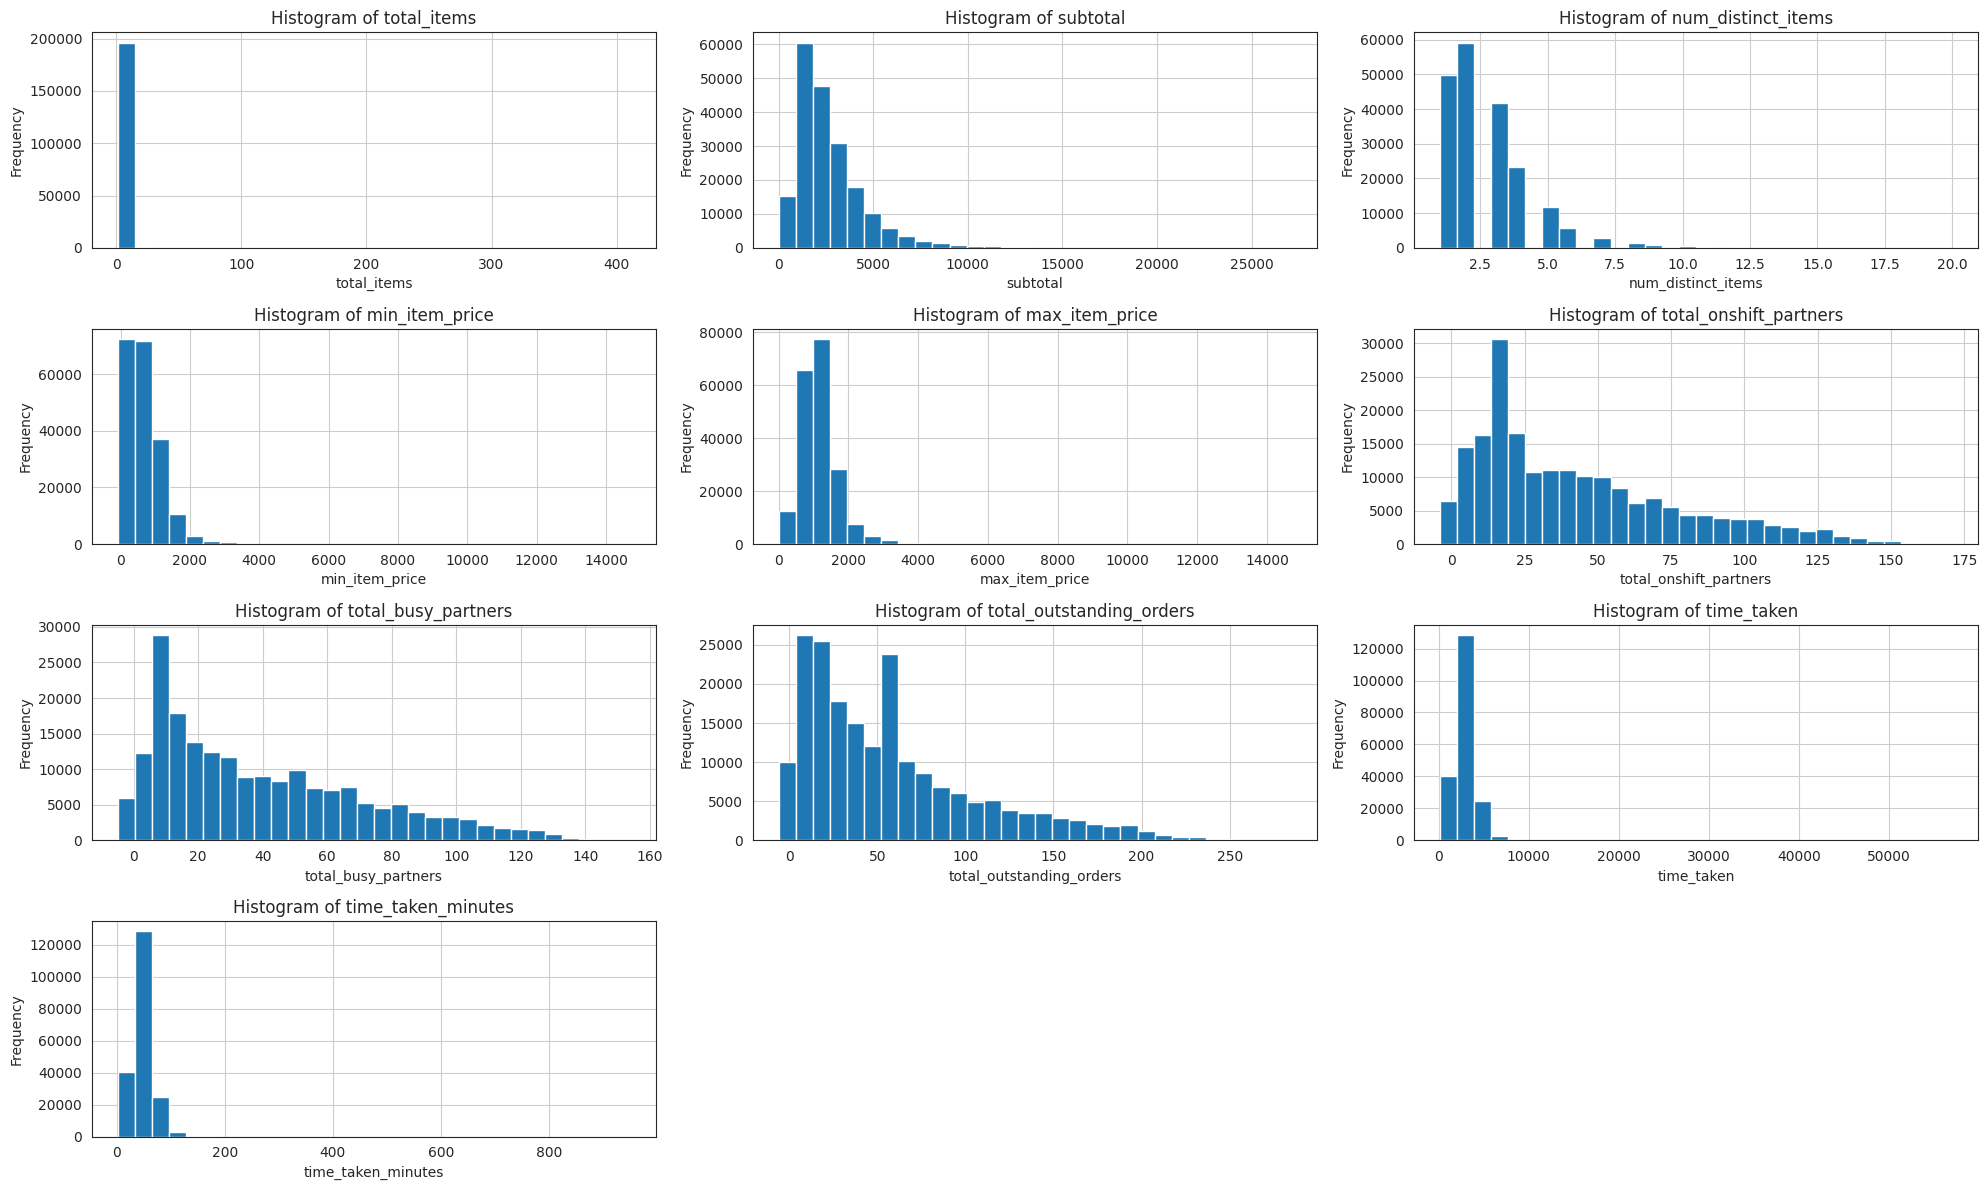

In [5]:
mean_time_taken = df['time_taken'].mean()
std_time_taken = df['time_taken'].std()
lower_bound = mean_time_taken - 3 * std_time_taken
upper_bound = mean_time_taken + 3 * std_time_taken
df = df[(df['time_taken'] >= lower_bound) & (df['time_taken'] <= upper_bound)]

numerical_columns = df.select_dtypes(include=['number']).columns
n_cols = len(numerical_columns)
n_rows = (n_cols // 3) + (n_cols % 3 > 0)

fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize=(n_rows * 5, n_rows * 3))

if n_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for i, col in enumerate(numerical_columns):
    ax = axes[i]
    df[col].hist(bins=30, ax=ax)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


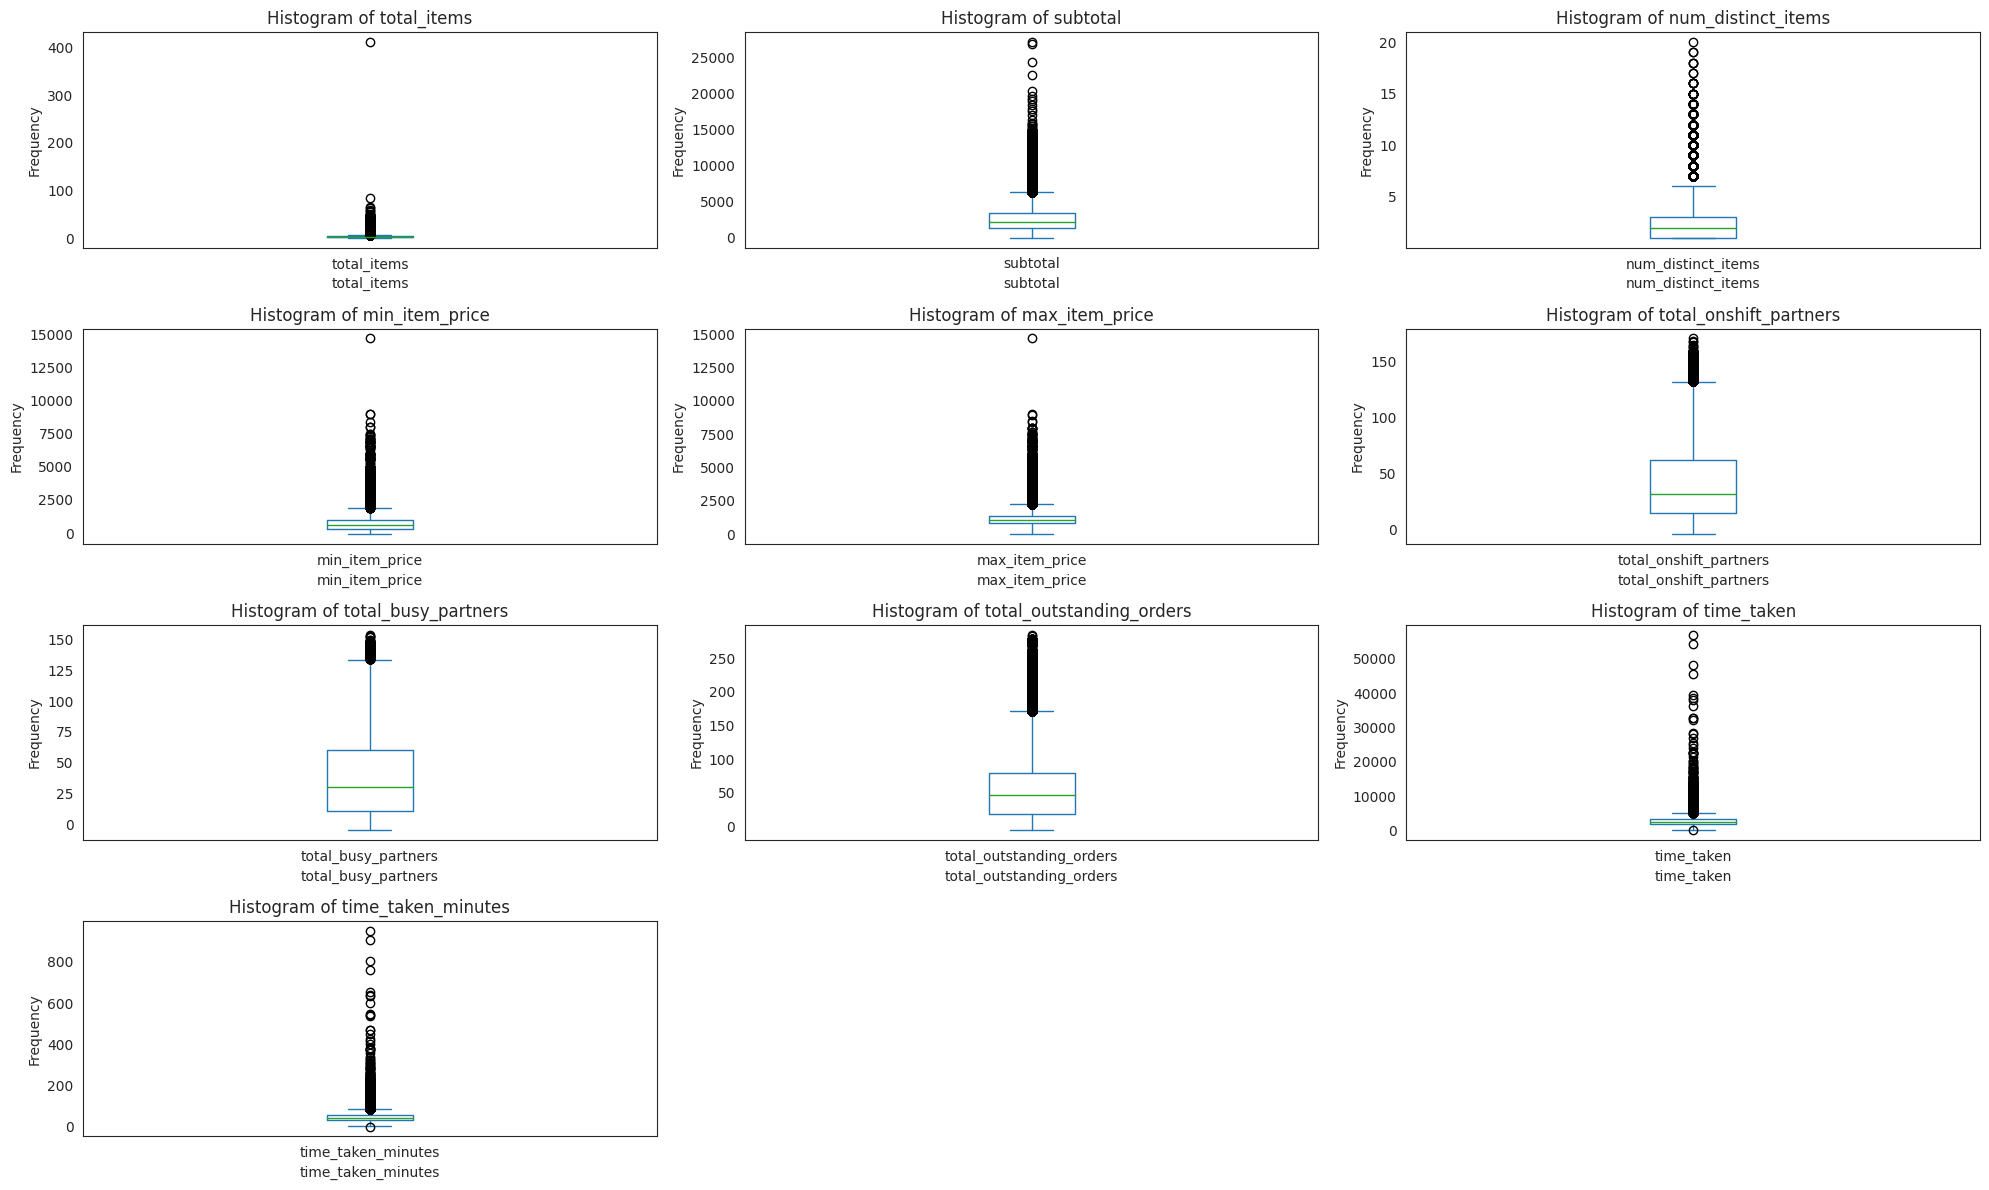

In [6]:
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize= (n_rows * 5, n_rows * 3))
if n_rows > 1:
  axes = axes.flatten()
else:
  axes = [axes]
for i, col in enumerate(numerical_columns):
  ax = axes[i]
  df[col].plot(kind= 'box', ax=ax)
  ax.set_title(f'Histogram of {col}')
  ax.set_xlabel(col)
  ax.set_ylabel('Frequency')
for j in range(i + 1, len(axes)):
  axes[j].set_visible(False)
plt.tight_layout()
plt.show()

1. Total Items vs. Time Taken: This plot indicates that most of the orders contain fewer items, and there's a cluster of data with lower time
taken values. There are outliers with a very high number of items which don't seem to follow a clear trend in relation to time taken,
suggesting other factors may influence delivery times more than the number of items.
2. Minimum Item Price vs. Time Taken: There's a significant number of orders clustered at the lower end of minimum item price, with time
taken for these orders being widely spread out. Orders with a very high minimum item price are rare and don't show a clear relationship
with time taken.
3. Total Busy Partners vs. Time Taken: We observe a large concentration of points where there are fewer busy partners, with time taken
appearing relatively consistent. This could indicate that the number of busy partners may not be a significant determinant of delivery time,
or there are capacity thresholds that once exceeded, do not impact delivery time.
4. Subtotal vs. Time Taken: Similar to total items, a higher subtotal does not appear to clearly correlate with longer or shorter delivery times.
Most orders have a lower subtotal, with the delivery time for these orders varying widely.
5. Maximum Item Price vs. Time Taken: The scatter plot does not show a clear trend between maximum item price and time taken. Orders
are clustered at the lower end of the max item price range, with no clear pattern indicating a relationship with time taken.
6. Total Outstanding Orders vs. Time Taken: There is some spread in time taken as the number of outstanding orders increases, which
might suggest that an increasing volume of orders correlates with greater variability in delivery time.
7. Number of Distinct Items vs. Time Taken: The data is clustered toward orders with fewer distinct items, and these do not show a strong
trend with time taken, suggesting that the complexity or variety of the order might not significantly impact delivery time.
8. Total Onshift Partners vs. Time Taken: A large number of onshift partners doesn't necessarily correspond with increased delivery time,
but the plot suggests a threshold above which the number of partners has less impact on delivery time.

These insights suggest that while there are some loose patterns in the data, there is no strong linear relationship between these features and
the time taken for delivery, indicating the need for a more complex model to predict delivery times accurately. It would be beneficial to also look
at the interaction between these features and other potential factors such as geographic location, traffic, and weather conditions.

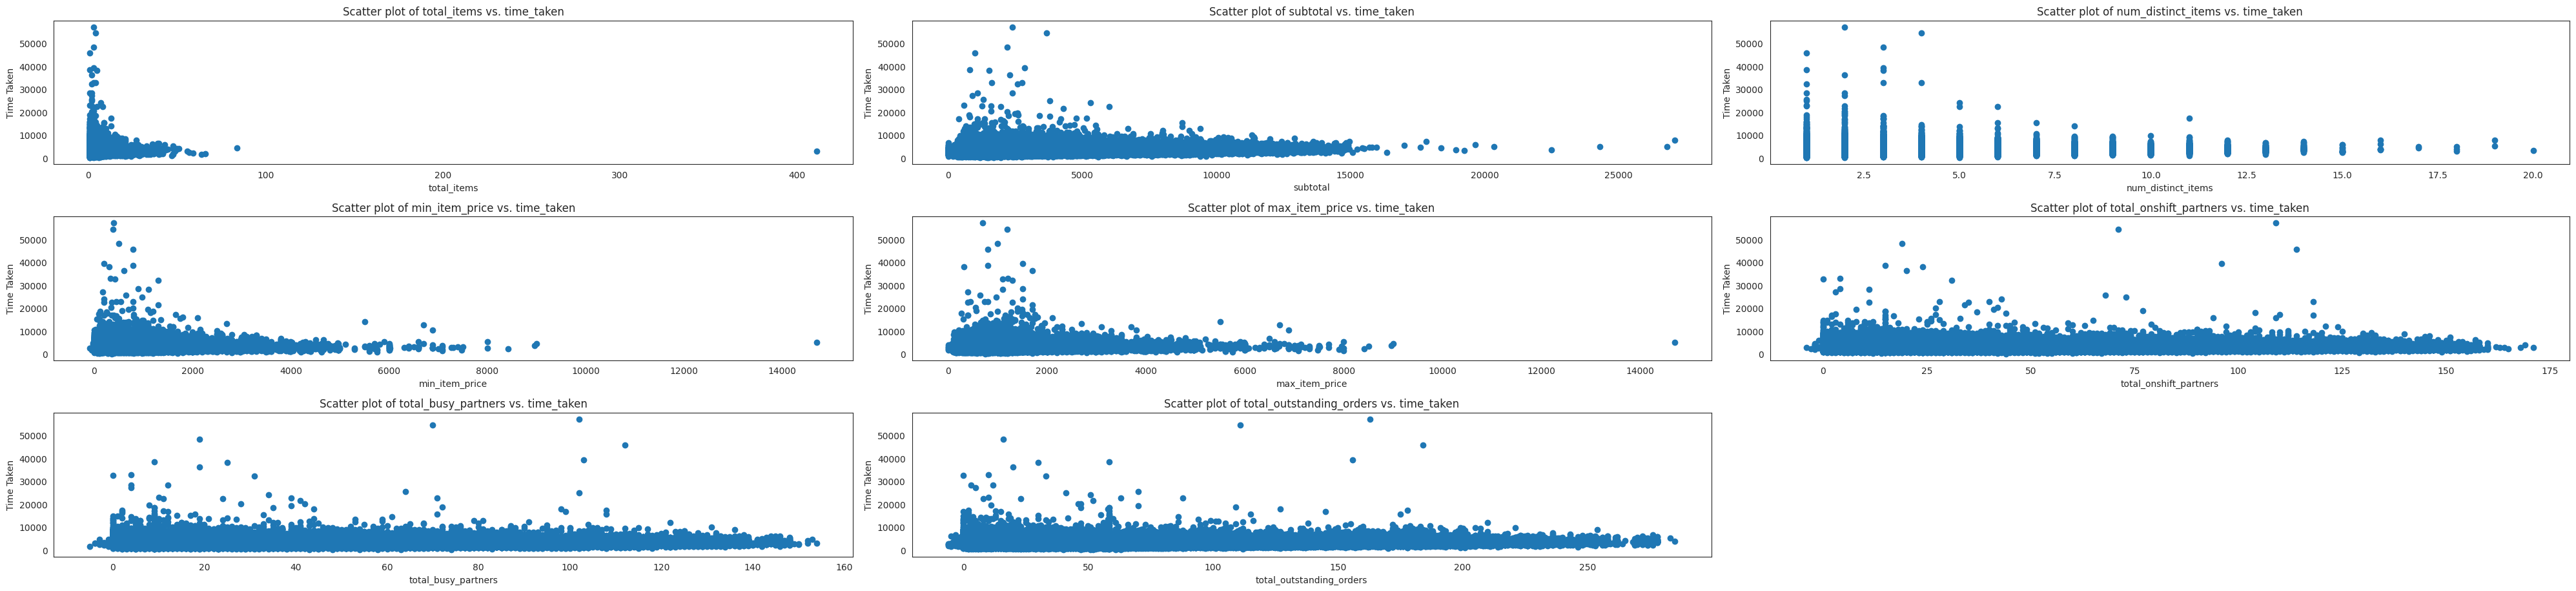

In [7]:
numerical_columns= ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']
n_rows= len(numerical_columns)
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize= (n_rows * 5, n_rows * 3))
if n_rows > 1:
  axes = axes.flatten()
else:
  axes = [axes]
for i, col in enumerate(numerical_columns):
  ax = axes[i]
  ax.scatter(df[col], df['time_taken'])
  ax.set_title(f'Scatter plot of {col} vs. time_taken')
  ax.set_xlabel(col)
  ax.set_ylabel('Time Taken')

for j in range(i + 1, len(axes)):
  axes[j].set_visible(False)

plt.tight_layout()

plt.show()

The heatmap indicates that there is a weak linear correlation between the independent variables and the target variable.

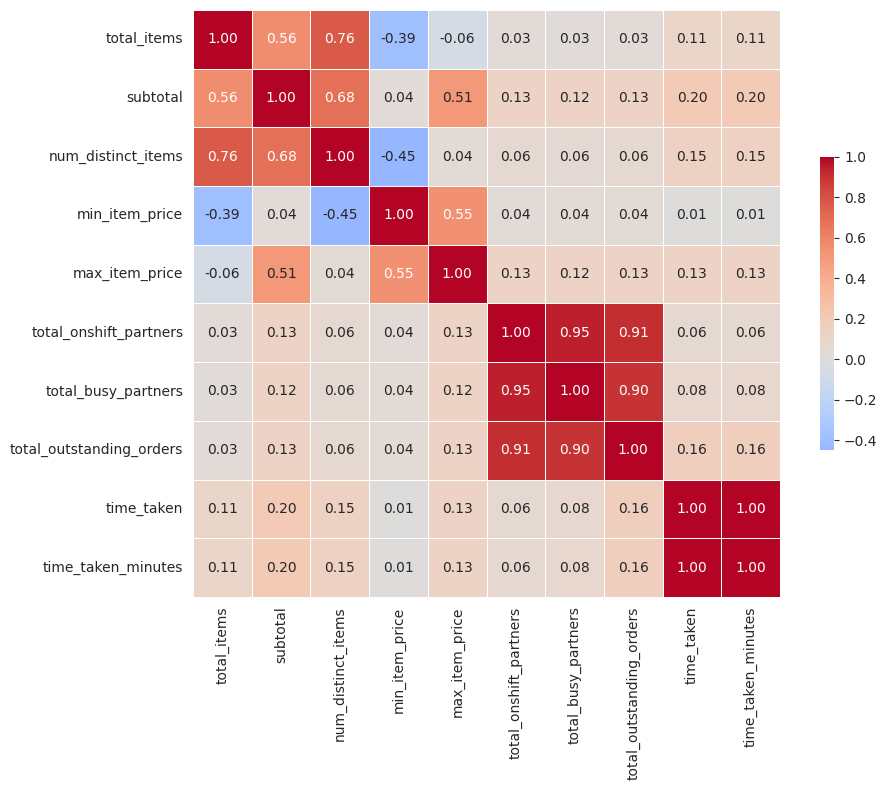

In [8]:
numerical_columns = df.select_dtypes(include='number').columns
corr = df[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.show()

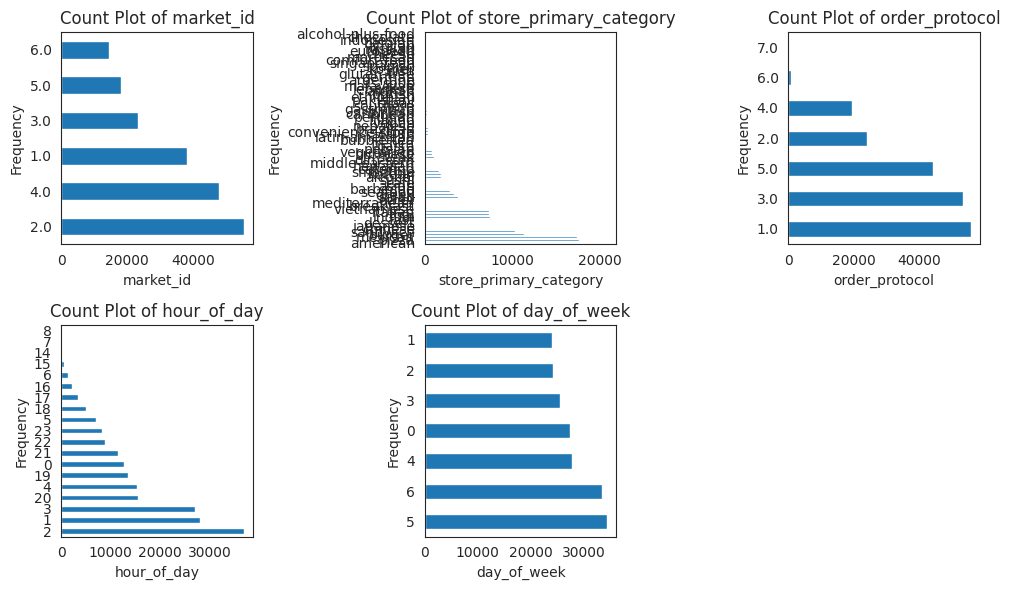

In [9]:
cat_columns = ['market_id', 'store_primary_category', 'order_protocol', 'hour_of_day', 'day_of_week']
n_cols = len(cat_columns)
n_rows = (n_cols // 3) + (n_cols % 3 > 0)
fig, axes = plt.subplots(nrows=n_rows, ncols=3, figsize= (n_rows * 5, n_rows * 3))

if n_rows > 1:
  axes = axes.flatten()
else:
  axes = [axes]

for i, col in enumerate(cat_columns):
  ax = axes[i]
  category_counts = df[col].value_counts()
  category_counts.plot(kind='barh', ax= ax)
  ax.set_title(f'Count Plot of {col}')
  ax.set_xlabel(col)
  ax.set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
  axes[j].set_visible(False)

plt.tight_layout()
plt.show()

2:00 AM through out the week seems to be popular time for orders
And orders seem to peak at Saturdays

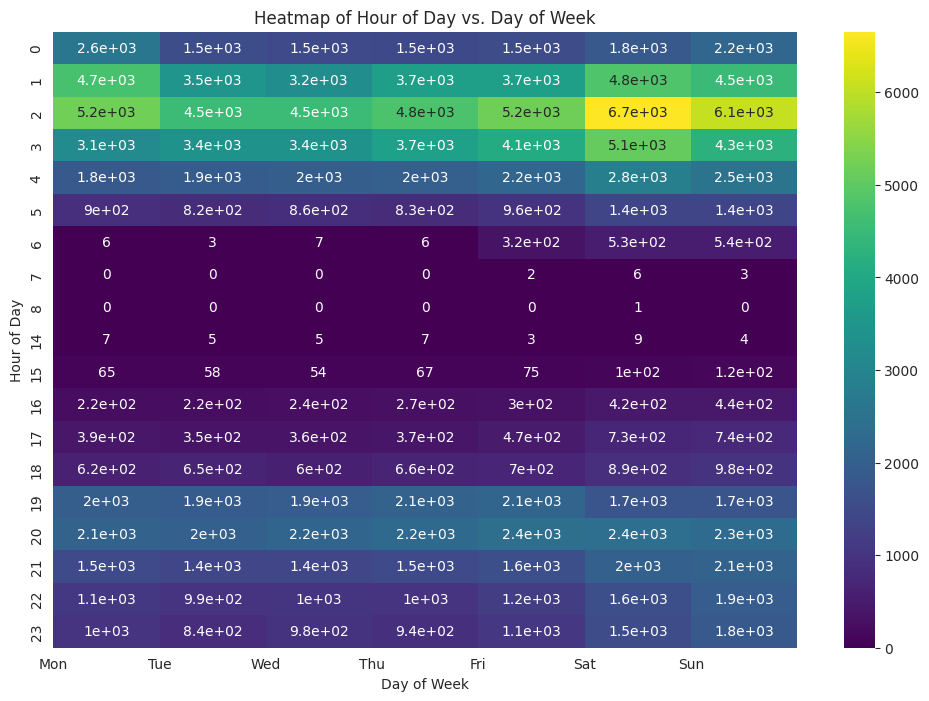

In [10]:
pivot_table = pd.crosstab(df['hour_of_day'], df['day_of_week'])
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=True)
plt.title('Heatmap of Hour of Day vs. Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.xticks(ticks=range(0, 7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

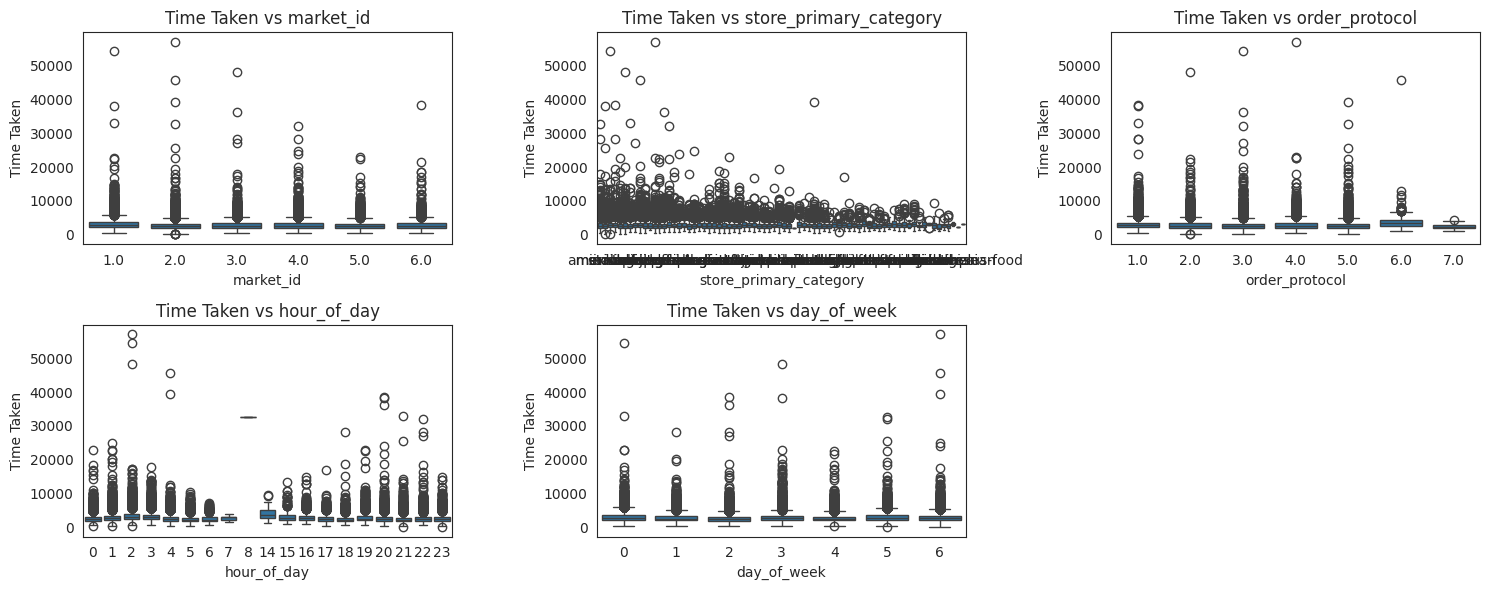

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_columns = ['market_id', 'store_primary_category', 'order_protocol', 'hour_of_day', 'day_of_week']
n_cols = 3
n_rows = (len(categorical_columns) // n_cols) + (len(categorical_columns) % n_cols > 0)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 3))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, column in zip(axes, categorical_columns):
    sns.boxplot(x=column, y='time_taken', data=df, ax=ax)
    ax.set_title(f'Time Taken vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Time Taken')

# Turn off unused subplots
for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [12]:
%%capture
!pip install category_encoders

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder

df.drop(['time_taken', 'created_at', 'actual_delivery_time'], axis=1, inplace=True)

categorical_columns = ['market_id', 'store_primary_category', 'order_protocol', 'hour_of_day', 'day_of_week', 'store_id']
numerical_columns = df.select_dtypes('number').drop(['time_taken_minutes'], axis= 1).columns

X = df.drop('time_taken_minutes', axis=1)
y = df['time_taken_minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

target_encoder = TargetEncoder(cols=categorical_columns)

X_train_encoded = target_encoder.fit_transform(X_train, y_train)
X_test_encoded = target_encoder.transform(X_test)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_encoded[numerical_columns])
X_test_scaled = scaler.transform(X_test_encoded[numerical_columns])

X_train_processed = np.concatenate((X_train_scaled, X_train_encoded.drop(numerical_columns, axis=1).values), axis=1)
X_test_processed = np.concatenate((X_test_scaled, X_test_encoded.drop(numerical_columns, axis=1).values), axis=1)

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
n_features = X_train_processed.shape[1]
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(n_features,)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
history = model.fit(X_train_processed, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)
test_loss = model.evaluate(X_test_processed, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 424.7232 - val_loss: 338.7866
Epoch 2/10
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 351.4305 - val_loss: 308.9297
Epoch 3/10
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 352.2431 - val_loss: 311.4389
Epoch 4/10
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 326.9305 - val_loss: 356.7165
Epoch 5/10
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 330.6278 - val_loss: 337.2561
Epoch 6/10
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 327.3828 - val_loss: 324.3843
Epoch 7/10
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 328.0024 - val_loss: 369.7387
Epoch 8/10
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 311.9801 - val_loss: 326.4396
Epoch 9/10
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 318.9190 - val_loss: 343.6380
Epoch 10/10
3949/3949 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 303.7570 - val_loss: 320.0297
Test Loss: 282.4879455566406


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

4936/4936 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
